In [8]:
print("Унікальні значення Exit Status:", data['Exit Status'].unique())

# Перетворення в нижній регістр для надійності
data['Exit Status'] = data['Exit Status'].astype(str).str.lower()

# Подивимось знову
print("Після зниження регістру:", data['Exit Status'].unique())

# Кодування: 1 — якщо містить "exit", інакше 0
data['Exit Status'] = data['Exit Status'].apply(lambda x: 1 if 'exit' in x else 0)

# Перевірити баланс класів
print(data['Exit Status'].value_counts())



Унікальні значення Exit Status: [0]
Після зниження регістру: ['0']
Exit Status
0    500
Name: count, dtype: int64


Розподіл класів у Exit Status:
 Exit Status
0    348
1    152
Name: count, dtype: int64


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.70
Precision: 0.50
Recall: 0.03
F1 Score: 0.06
Матриця плутанини:
[[69  1]
 [29  1]]


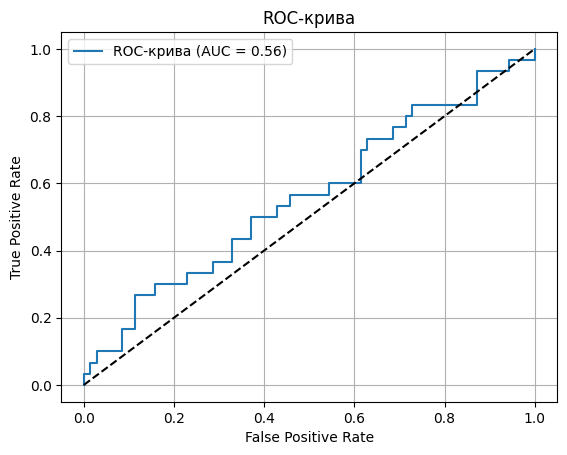

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# === 1. Завантаження даних ===
data = pd.read_csv("startup_data.csv")  # заміни шлях на свій

# === 2. Обробка 'Exit Status' ===
# Переводимо в нижній регістр
data['Exit Status'] = data['Exit Status'].astype(str).str.lower()

# Визначаємо, що вважається успішним виходом
success_keywords = ['exited', 'acquired', 'ipo']

# Присвоюємо 1 для успішного виходу, 0 — інакше
data['Exit Status'] = data['Exit Status'].apply(
    lambda x: 1 if any(word in x for word in success_keywords) else 0
)

# Перевіримо баланс класів
print("Розподіл класів у Exit Status:\n", data['Exit Status'].value_counts())

# Якщо один клас — неможливо тренувати модель
if data['Exit Status'].nunique() < 2:
    raise ValueError("Недостатньо класів у 'Exit Status' для класифікації.")

# === 3. Обробка 'Profitable' ===
data['Profitable'] = data['Profitable'].astype(str).str.lower().apply(lambda x: 1 if x == 'yes' else 0)

# === 4. Заповнення пропущених значень ===
for col in ['Funding Amount (M USD)', 'Valuation (M USD)', 'Revenue (M USD)', 'Employees', 'Market Share (%)']:
    if data[col].isnull().any():
        data[col].fillna(data[col].mean(), inplace=True)

# === 5. Кодування категоріальних змінних ===
data = pd.get_dummies(data, columns=['Industry', 'Region'], drop_first=True)

# === 6. Формування X та y ===
X = data.drop(columns=['Startup Name', 'Exit Status'])  # ознаки
y = data['Exit Status']  # цільова змінна

# === 7. Розділення на train/test ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === 8. Модель ===
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# === 9. Прогноз та оцінка ===
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Матриця плутанини
print("Матриця плутанини:")
print(confusion_matrix(y_test, y_pred))

# === 10. ROC-крива ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC-крива (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-крива')
plt.legend()
plt.grid()
plt.show()
